# Spectroscopics studies of molecular complex of mesitylene donor with iodine by constant activity method

The aim of this experiment is to determin spectroscopic properties of charge-transfer complex (mesytilene -- I$_2$) and to detremine equilibrium constant of the complex.
Equilibrium constants and ex. coefficient are determined from UV\VIS spectra, since it is possible to calculate exact concentrations of species usin Beer-Lambert equation.

Experiment is divided into two parts. The first part corresponds to determination of adequate experimental parameters for further measurement and for determination of spectral properties of pure forms.
Three separate spectra are taken in cyclohexane (this is the solute for all the experiment): 
- spectrum of I$_2$ at $2.5 10^{-4}$ M. Concentration of I$_2$ is approximate, knowing it's $\epsilon$ at $\lambda = 520$ nm, we need to calculate I_$_2$ true concentration.
- spectrum of mesytilene at $1$ M. From the spectrum we will determine $\epsilon$ at $\lambda$ of our interest (absorption of complex $330$ and $360$ nm) and use it to predict absorbance at wavelengths, knowing exact concentrations of mesytilene. 
- spectrum of complex. To deteriment maximum of absorbance for complex specie.

The second part of the experiment is to take 5-6 solution with constant concentration of I$_{2}$ and various concentrations of mesytilene and measure their spectra. From obtained spectra, we can determine concentration of each specie and calculate equilibrium constant, since:

$A + B = C$

$K = \frac{[C]}{[A][B]}$

- $[C] = x $
- $[A] = A_0 - x$
- $[B] = B_0 - x$

$K = \frac{x}{(A_0 - x)(B_0 - x)}$

# Import libraries

In [1]:
import numpy as np # math
import matplotlib.pyplot as plt
import re
import glob
from sklearn.metrics import r2_score

# Determine constants

In [2]:
lambda_1         = 331
lambda_2         = 360
lambda_I_520    = 520 # spectral properties of pure iodine - max wavelength
epsilon_I_520   = 968 # spectral properties of pure iodine - ex. coefficient
L = 1
C_zero_mesytilene = 2
V_vial = 5
V_mesytilene = np.array([4, 3, 2.5, 2, 0.5]) # The volume of mesytilene in accordance with instructions

where
- $\lambda_1$  - wavelength of interest: absorbance maximum of complex  
- $\lambda_2 $ - additional wavelength of interest: absorbance maximum of complex 
- $\lambda_{I_{520}}$ - wavelength of maximum absorbance on I$_2$ spectrum
- $epsilon_{I_{520}}$ - ex. coefficient at $\lambda_{520}$ for I$_2$, $M^{-1} cm^{-1}$
- $L = 1$ - cuvette optical path, cm
- $C^0_{mesytilene}$ - initial concentration of mesytilene in cyclohexane mother solution, M
- $V_{vial}$ - flask volume, ml
- $V_{mesytilene}$ - The volume of mesytilene taken for dilution in accordance with instructions

# Concentrations of mesytilene
Concentration of donor in solutions of complex, M

In [3]:
C_final_mesytilene = C_zero_mesytilene * V_mesytilene / V_vial
print("C(mesytilene) =", C_final_mesytilene, "M")

C(mesytilene) = [1.6 1.2 1.  0.8 0.2] M


# Load data

In [4]:
compounds = {}
compounds["spectra_I2"] = { "filename": "Original_I2.txt",
                     "title": "Iodine"}

compounds["spectra_mes"] = { "filename": "Original_mesitylene.txt",
                    "title": "Mesitylene"}

compounds["spectra_complex"] =   { "filename": "Original_complex.txt",
                     "title": "Complex"}

for type, info in compounds.items():
    wavelength, absorbance = np.loadtxt(info["filename"], unpack=True, delimiter='\t',skiprows=18)
    compounds[type]["wavelength"] = wavelength
    compounds[type]["absorbance"] = absorbance 

# Load experimental spectra into dictionary

In [5]:
filenames = sorted(glob.glob('exp*.txt'))
experiment = {}
keys = range(len(filenames))
for i in keys:
        experiment[i+1] = {"filename": filenames[i], "title": C_final_mesytilene[i]}
  
for type, info in experiment.items():
    wavelength, absorbance = np.loadtxt(info["filename"], unpack=True, delimiter='\t',skiprows=18)
    experiment[type]["wavelength"] = wavelength
    experiment[type]["absorbance"] = absorbance

# Concentration of Iodine should be derived from spectra of I$_2$

In [6]:
idx_I = np.where(compounds["spectra_I2"]["wavelength"] == lambda_I_520)
A_I_concentration = compounds["spectra_I2"]["absorbance"][idx_I][0]
C_final_I_spectra  = A_I_concentration / (L * epsilon_I_520)
print("C(I2)=", C_final_I_spectra, "M")

C(I2)= 0.0002196694214876033 M


# Huge function for K and $\epsilon$ determination at different $\lambda$

In [7]:
def find_molar_mass(lambda_x, compounds, experiment, C_final_mesytilene, C_final_I_spectra):
    # Find absorbance at given lambda in spectra of pure compounds
    A_I     = compounds["spectra_I2"]["absorbance"][np.where(compounds["spectra_I2"]["wavelength"] == lambda_x)][0]
    A_mes   = compounds["spectra_mes"]["absorbance"][np.where(compounds["spectra_mes"]["wavelength"] == lambda_x)][0]

    # A = A_I + A_mes + A_complex => 
    A = []
    for type, info in experiment.items(): 
        exp = experiment[type]
        A.append(experiment[type]["absorbance"][np.where(experiment[type]["wavelength"]==lambda_x)][0])
    A = np.array(A)

    # Calculate absorbance of complex: A_3, calculate x and y
    A_3 = []
    x   = []
    y   = []
    for i in range(len(C_final_mesytilene)):
        # A_complex = A_all - A_i2 - A_mes => where A = epsilon C L
        A_3_inner = A[i] - (A_mes * L * C_final_mesytilene[i]) - A_I
        x_inner = A_3_inner / C_final_I_spectra
        y_inner = A_3_inner / (C_final_I_spectra * C_final_mesytilene[i])
        A_3.append(A_3_inner)
        x.append(x_inner)
        y.append(y_inner)
    
    # Perform linear fitting
    function_fitted = np.polyfit(x,y,1)
    predict = np.poly1d(function_fitted)
    x_lin_reg = range(300,3000)
    y_lin_reg = predict(x_lin_reg)

    # Derive K and epsilon
    K       = -function_fitted[0]
    epsilon = function_fitted[1]/K

    # Error calculation
    R2 = r2_score(y, predict(x))
    
    return K, epsilon, R2, x_lin_reg, y_lin_reg, x, y

where $x=A_{complex} / C_{I_2}$, $y = A_{complex} / C_{I_2}C_{mes}$

Since $A = \epsilon C L$, where C is concentration and L is length of cuvette, we can rewrite:

$A_{all} = A_{I_2} + A_{complex} + A_{mes}$

as:

- $A_{I_2} = \epsilon_{I_2\lambda_1}  [C(I_2) - C(complex)] L$
- $A_{mes} = \epsilon_{mes\lambda_1} [C(mes) - C(complex)] L$, but since mesytilene is actually taken in greater concentrations then any other compound, we can write:
 $A_{mes} = \epsilon_{mes\lambda_1} C(mes) L$
- $A_{complex} = \epsilon_{complex\lambda_1}  C(complex) L$

To calculate absorbance of complex:
$A_{complex} = A_{all} - A_{I_2} - A_{mes}$ or $A_{complex} = A_{all} - \epsilon_{\lambda_1}  [C(I_2) - C(complex)] L - \epsilon_{\lambda_1} C(mes) L$

Apply this to equilibrium constant equation:

$K=\frac{X}{(C_{I_2}-X)(C_{mes}-X)} = \frac{X}{(C_{I_2}-X)C_{mes}}$

To receive: 

$\frac{A_{complex}}{C_{I_2}C_{mes}} = L \epsilon_{complex} K - \frac{A_{complex}}{C_{I_2}} K $

which gives a great opportunity to calculate K and $\epsilon$ simply from linear graph of $y=ax+b$ type

# Calculate K and $\epsilon$ for $\lambda = 330$ and $360$ nm 

In [8]:
K, epsilon, R2, x_lin_reg, y_lin_reg, x, y = find_molar_mass(lambda_1, compounds, experiment, C_final_mesytilene, C_final_I_spectra)
K2, epsilon2, R22, x_lin_reg2, y_lin_reg2, x2, y2 = find_molar_mass(lambda_2, compounds, experiment, C_final_mesytilene, C_final_I_spectra)

print(f'equilibrium constnat K = {K:.3f} (1/M) found at {lambda_1:.0f} nm, ex. coefficient = {epsilon:.2f}')
print(f'equilibrium constnat K = {K2:.3f} (1/M) found at {lambda_2:.0f} nm, ex. coefficient = {epsilon2:.2f}')

equilibrium constnat K = 0.655 (1/M) found at 331 nm, ex. coefficient = 5027.22
equilibrium constnat K = 0.558 (1/M) found at 360 nm, ex. coefficient = 2767.20


# Plot figures

## Plot spectra

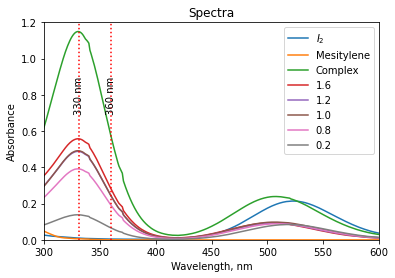

In [9]:
legend = ['$I_2$','Mesitylene', 'Complex']
for i in range(len(C_final_mesytilene)):
    legend.append(C_final_mesytilene[i])

for type, info in compounds.items():
     data = compounds[type]
     plt.plot(data["wavelength"], data["absorbance"], label = data["title"])
for type, info in experiment.items():     
     exp  = experiment[type]
     plt.plot(exp["wavelength"], exp["absorbance"], label = exp["title"])
plt.axvline(x=lambda_1, color = 'r', label = lambda_1, linestyle='dotted')
plt.text(lambda_1, 0.8, '330 nm', ha='center', va='center',rotation='vertical')
plt.axvline(x=lambda_2, color = 'r', label = lambda_1, linestyle='dotted')
plt.text(lambda_2, 0.8, '360 nm', ha='center', va='center',rotation='vertical')
plt.title(r'Spectra')
plt.xlabel(r'Wavelength, nm')
plt.ylabel(r'Absorbance')
plt.xlim([300, 600])
plt.ylim([0, 1.2])
plt.legend(legend)
plt.show()

## Plot linear dependence and show result

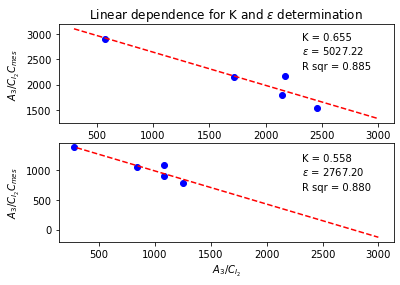

In [13]:
plt.figure(1)
plt.subplot(211)
plt.plot(x,y, 'bo', x_lin_reg, y_lin_reg, 'r--')
plt.ylabel(r'$A_3/C_{I_2} C_{mes}$')
plt.title(r'Linear dependence for K and $\epsilon$ determination')
plt.annotate(f"K = {K:.3f}",xycoords='figure fraction', xy=(0.7, 0.85))
plt.annotate(f"$\epsilon$ = {epsilon:.2f}", xycoords='figure fraction', xy=(0.7, 0.80))
plt.annotate(f"R sqr = {R2 :.3f}", xycoords='figure fraction', xy=(0.7, 0.75))
plt.subplot(212)
plt.plot(x2,y2, 'bo', x_lin_reg2, y_lin_reg2, 'r--')
plt.xlabel(r'$A_3/C_{I_2}$')
plt.ylabel(r'$A_3/C_{I_2} C_{mes}$')
plt.annotate(f"K = {K2:.3f}",xycoords='figure fraction', xy=(0.7, 0.43))
plt.annotate(f"$\epsilon$ = {epsilon2:.2f}", xycoords='figure fraction', xy=(0.7, 0.38))
plt.annotate(f"R sqr = {R22 :.3f}", xycoords='figure fraction', xy=(0.7, 0.33))
plt.show()